<a href="https://colab.research.google.com/github/gcfer/reinforcement-learning/blob/main/RL_PPO_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning: PPO (Proximal Policy Optimization)

## Overview

In this notebook, we'll discuss proximal policy algorithms, and implement a version of `PPO`, the state-of-the-art proximal policy algorithm. We'll test it by solving the cartpole problem in the Open AI gym. 

In [ ]:
import numpy as np
import pandas as pd
import datetime
import copy

# Import tensorflow
#!pip install tensorflow-gpu==1.14.0 > /dev/null 2>&1
import tensorflow as tf
import tensorflow.keras as K
print(tf.__version__)

# Check that tf sees the GPU
device_name = tf.test.gpu_device_name()
print(device_name)

# Import libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # this makes plot in high res

2.3.0



Since we are in a remote notebook, we cannot display the progress of the environment in real time. Instead, we store the renderings and show a video at the end of the episode (refer to [this](https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/) guide in case you need it). The only advice that I can give is to import `gym` _after_ the update below.

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
# Maybe
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !pip install gym[atari] > /dev/null 2>&1

In [ ]:
# Open AI gym
import gym 
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import math
import random
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(2880, 1800))
display.start()

The function below is needed to display the video. I slightly modified it from the original one (that you can in the guide I linked above) to avoid the infinite repetition loop of the video.

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## OpenAI Gym Cartpole

The Cartpole problem is a discrete control problem where we try to keep the pole vertical by moving the cart below it. 

Upon loading the environment, we launch a simulation where the agent chooses at random from the action sample space the next action. Finally, we show the video of the result. What happens is that the problem is considered unsolved (= game over) if the angle between pole and the line orthogonal to the cart axis is larger than a threshold. The parameter `done` specifies when the experiment is over.

In [ ]:
# Load the environment and start
env = wrap_env(gym.make("CartPole-v0"))

In [ ]:
observation = env.reset()

while True:
  
    env.render()
    
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
    if done: 
      break;
            
env.close()

In [ ]:
show_video()

To better understand the inputs and outputs of the environment, let consider the action space and the observation space.

The action space is of type `Discrete(n)` where `n` is the number of actions. This is equivalent to the discrete set $\{ 0, 1, 2, \dotsc, n-1 \}$.

In [ ]:
env.action_space

Discrete(2)

The observation space is of type `Box(n)`, which means that it is the Cartesian product of `n` intervals.

In [ ]:
env.observation_space

Box(4,)

In [ ]:
[env.observation_space.low, env.observation_space.high]

[array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32)]

When we make a step in the environment, the feedback that we get includes the observation:

In [ ]:
#env = gym.make('CartPole-v0')
# env = Monitor(env, './video', force=True)
env.reset()

obs, r, done, _ = env.step(0)
print(obs)

[ 0.04481061 -0.21897167  0.0430095   0.25740089]


## Proximal Policy Optimization

Proximal policy algorithms are policy gradient algorithms that try to speed up convergence. The main idea behind proximal policy is that we want to train the network by making a big step during each episode but not as big as making it difficult, or impossible, for the algorithm to converge.

Recall that in `REINFORCE` we seek to minimize
$$ L_{\mathrm{REINFORCE}}(\tau) = -\mathbf{E}_{\pi_\theta}[ R(\tau) ] \sim -\sum_{t=1}^{T} \pi_\theta(a_t|s_t)R(s_t,a_t) $$
and in advantage actor critic algorithms (e.g. `A2C`) 
$$ L_{\mathrm{A2C}}(\tau) = -\mathbf{E}_{\pi_\theta}[ A(\tau) ] \sim -\sum_{t=1}^{T} \pi_\theta(a_t|s_t)A(s_t,a_t) $$
with respect to the policy $\pi_\theta$. 

In `PPO`, we seek to minimize a slightly different version of such losses. First, we use importance sampling by choosing another distribution $\pi_{\theta'}$ and minimize the loss with respect to the new policy while keeping the old policy fixed $\pi_{\theta}$:
$$ \theta^* = \arg\max_{\theta'} \sum_{t=1}^{T} \frac{1}{\pi_{\theta}(a_t|s_t)} \pi_{\theta'}(a_t|s_t) A(s_t,a_t). $$
Notice that decisions are taken with respect to the old policy $\pi_\theta$. This has the effect of neutralizing the factor $1/\pi_\theta$ since the above objective function tends asymptotically to the reward we would get with the new policy. In practice, we can repeat this optimization iteratively starting with some $\theta=\theta_0$ and updating the policy as follows:
$$ \theta_{k+1} = \arg\max_{\theta'} \sum_{t=1}^{T} \frac{1}{\pi_{\theta_k}(a_t|s_t)} \pi_{\theta'}(a_t|s_t) A(s_t,a_t). $$

Second, since we are optimizing with respect to $\theta'$, the system may be unstable (small variations in the parameter can cause big variations in the policy, and in turn in the objective function). One way to fix this issue is to constrain $\pi_{\theta'}$ and $\pi_{\theta_k}$ to be close in the variational sense, e.g. by constraining the Kullback–Leibler divergence. This is the idea behind TRPO. 

Alternatively, we can more quickly and more roughly just clip the policy if the change is deemed to be too big. This is the idea behind one form of `PPO`. 

There are two cases to investigate since the advantage can have both signs. If $A>0$, then $\pi_{\theta'}/\pi_{\theta_k}$ can explode because we are maximizing the objective function, and hence we will clip the ratio at some value such as $1+\epsilon$. If $A < 0$, then the ratio can vanish because the maximum is zero in that case, and hence we will clip the ratio at some value such as  $1-\epsilon$. 

In summary, `PPO` updates the policy as follows:
$$ \theta_{k+1} = \arg\max_{\theta'} \sum_{t=1}^{T} \left[ \left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)} \wedge(1+\epsilon) \right)  A(s_t,a_t) \mathbf{1}_{A(s_t,a_t)\geq 0} + \left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)} \vee (1-\epsilon) \right)  A(s_t,a_t) \mathbf{1}_{A(s_t,a_t)< 0}\right] $$
where $\wedge$ and $\vee$ are shorthands for min and max (like in logic).

In [ ]:
# PPO - Proximal Policy Optimization
class PPO:
  
  def __init__(self, state_size, action_size, gamma=None, max_steps=None, epsilon=None):
    # max_steps is the maximum number of batches [s, a, r, s_] or epochs remembered
    
    # Parameters
    self.state_size = state_size
    self.action_size = action_size
    
    self.memory = list()

    if gamma is None: 
      self.gamma = 0.99
    else: 
      self.gamma = gamma
    
    if max_steps is None:
      self.max_steps = 200 
    else:
      self.max_steps = max_steps

    if epsilon is None:
      self.epsilon = 0.2
    else:
      self.epsilon = epsilon

    # learning rates
    self.actor_lr = 0.003
    self.critic_lr = 3 * self.actor_lr

    # actor network
    self.actor = self.build_actor()
    self.actor_old = tf.keras.models.clone_model(self.actor)

    # critic network
    self.critic = self.build_critic()

  def remember(self, s, a, r, s_, done):
    self.memory.append([s, a, r, s_, done])
    if len(self.memory) > self.max_steps: # if too long
      self.memory.pop(0) # forget the oldest
  
  def forget(self):
    self.memory = list()

  def custom_loss(self, y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)

    actions_one_hot, A, pol_old = tf.split(y_true, [self.action_size, 1, self.action_size], 1)
    advantages = tf.keras.backend.flatten(A)

    pol = y_pred

    probs = tf.reduce_sum(tf.math.multiply(actions_one_hot, pol), axis=1)
    probs = tf.clip_by_value(probs, 1e-9, 1.0)
    log_probs = tf.math.log(probs)

    probs_old = tf.reduce_sum(tf.math.multiply(actions_one_hot, pol_old), axis=1)
    probs_old = tf.clip_by_value(probs_old, 1e-9, 1.0)

    ratio = tf.math.divide(probs, probs_old)
    ratio_clip = tf.clip_by_value(ratio, 1-self.epsilon, 1+self.epsilon)

    kl_sum = tf.reduce_sum(tf.multiply(probs_old, -tf.math.log(ratio)))  # integral pi_old log(pi_old/pi)
    
    # A2C
    # loss = tf.reduce_sum(tf.math.multiply(-log_probs, advantages))

    # TRPO
    # beta = 1
    # loss = - tf.reduce_sum(w_adv) + beta * kl_sum

    # PPO
    # w_adv = tf.math.multiply(ratio, advantages)  # weighted averages, no clip
    surr_1 = tf.math.multiply(ratio_clip, advantages)  # alternative
    surr_2 = tf.math.multiply(ratio, advantages)
    min_surr = tf.minimum(surr_1, surr_2)
    loss = -tf.reduce_sum(min_surr)

    # Regularizations
    # 1. Entropy
    # entropy_sum = tf.reduce_sum(tf.math.multiply(probs, -tf.math.log(probs)))
    # loss -= 0.1 * entropy_sum
    # 2. KL (TRPO)
    # loss += kl_sum   

    # zeros = tf.zeros_like(advantages)
    # mask_pos = tf.greater(advantages, zeros)  # True/False mask, same size as zeros
    # adv_pos = tf.boolean_mask(adv, mask_pos)
    # ratio_pos = tf.boolean_mask(ratio, mask_pos)
    # clip_ratio_pos = tf.clip_by_value(ratio_pos, 1-self.epsilon, 1+self.epsilon)

    # mask_neg = tf.less(advantages, zeros)  # True/False mask, same size as zeros
    # adv_neg = tf.boolean_mask(adv, mask_neg)
    # ratio_neg = tf.boolean_mask(ratio, mask_neg)
    # clip_ratio_neg = tf.clip_by_value(ratio_neg, 1-self.epsilon, 1+self.epsilon)

    # # compute loss
    # loss = - tf.reduce_sum(tf.math.multiply(adv_pos, clip_ratio_pos)) \
    #        - tf.reduce_sum(tf.math.multiply(adv_neg, clip_ratio_neg)) \
    #        - 0.1 * tf.reduce_sum(tf.math.multiply(probs, -tf.math.log(probs)))  # regularization

    # loss = - tf.reduce_sum(adv)

    return loss

  # actor learns the policy: input is state; output is distribution over actions (policy)
  def build_actor(self):
    n_hidden = 10 * self.state_size

    input_layer = K.layers.Input((self.state_size, ))
    output_layer = K.layers.Dense(n_hidden, activation='elu')(input_layer)
    output_layer = K.layers.Dense(n_hidden, activation='elu')(output_layer)
    output_layer = K.layers.Dense(self.action_size, activation='softmax')(output_layer)

    weight_layer = K.layers.Input((self.state_size, ))
    weight_layer.trainable = False

    pol_old_layer = K.layers.Input((self.action_size, ))
    pol_old_layer.trainable = False

    model = K.models.Model([input_layer, weight_layer, pol_old_layer], output_layer)
    
    # loss is customized for PPO
    model.compile(optimizer=K.optimizers.RMSprop(lr=self.actor_lr), loss=self.custom_loss)
    
    return model

  # critic network
  def build_critic(self):
  
    n_hidden = 10 * self.state_size
  
    model = K.Sequential()
    model.add(K.layers.Dense(n_hidden, activation=tf.nn.elu, input_dim=self.state_size))  # first hidden layer
    model.add(K.layers.Dense(n_hidden, activation=tf.nn.elu))
    model.add(K.layers.Dense(1, activation=tf.nn.elu))  # output

    model.compile(optimizer=K.optimizers.RMSprop(lr=self.critic_lr), loss='mse')
    
    return model

  # actor implements policy gradient
  def policy(self, s):
    policy = self.actor.predict(s, batch_size=1).flatten()
    a = np.random.choice(self.action_size, 1, p=policy)[0]
    return a

  # learn from memory
  def learn(self):

    # replay the entire episode
    s, a, r, s_, done = zip(*self.memory)
    a = np.reshape(a, (-1, 1))
    
    T = a.shape[0] # epochs in memory
    a_one_hot = np.zeros((T, self.action_size))
    a_one_hot[np.arange(T), a.reshape(-1)] = 1   # size: T x action_size
    
    target_actor = a_one_hot # actions
    
    cum_reward = np.cumsum((self.gamma ** np.arange(0, T)) * r)/(self.gamma ** np.arange(0, T))
    R = np.flip(cum_reward).reshape(-1, 1)
    s = np.concatenate(s) # or np.vstack(s)  
    v = self.critic.predict(s)
    A = R - v  # theoretical advantage (infinite-horizon problems)

    # s_ = np.concatenate(s_)
    # v_ = self.critic.predict(s_)
    # r = np.reshape(r, (-1, 1))
    # A = r + self.gamma * v_ - v  # advantage (same as above but works better in finite-horizon problems)

    pol_old = self.actor_old.predict(s, batch_size=len(s))
    target_actor_plus = np.concatenate([target_actor, A, pol_old], axis=1)    
    self.actor.fit(s, target_actor_plus, epochs=1, verbose=0)  # advantages are in the output
    
    self.actor_old = tf.keras.models.clone_model(self.actor)
    # self.actor_old.build((None, self.state_size+1+self.custom_loss)) 
    # self.actor_old.compile(optimizer='rmsprop', loss=self.custom_loss)
    self.actor_old.set_weights(self.actor.get_weights())
    
    # fit critic
    self.critic.fit(s, R, epochs=1, verbose=0)  # trained to get the value function 

## Training



In [ ]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

# Restart environment
# env = Monitor(env, './video', force=True)
MAX_REWARD = 200
env._max_episode_steps = MAX_REWARD
n_avg_reward = 50

# Parameters
n_episodes = 300
reward_history = np.zeros(n_episodes)
gamma = 0.9
steps_in_memory = MAX_REWARD  # number of steps to remember

A = np.arange(env.action_space.n)
dim_state_space = env.observation_space.shape[0]

# Start training
agent = PPO(dim_state_space, env.action_space.n, gamma, steps_in_memory)

# init
s = env.reset()
s = np.reshape(s, [1, dim_state_space])

template = "\rEpisode: {:3d}/{:3d} | Reward: {:3.0f} | Avg reward (last {:2.0f} episodes): {:4.2f} | Episode duration: {:.2f} s"

In [ ]:
for e in range(n_episodes):
  start_time = datetime.datetime.now()

  s = env.reset()
  s = np.reshape(s, [1, dim_state_space])
  
  done = False
  cum_reward = 0
  
  while not done:
    
    a = agent.policy(s)
    s_, r, done, _ = env.step(a)
    s_ = np.reshape(s_, [1, dim_state_space])
    agent.remember(s, a, r, s_, done)
    cum_reward += r
    s = s_

  agent.learn()
  agent.forget()
  
  reward_history[e] = cum_reward

  if e > n_avg_reward:
    avg_reward = np.mean(reward_history[e-n_avg_reward:e+1])
  else:
    avg_reward = np.mean(reward_history[:e+1])

  dt = datetime.datetime.now() - start_time
  print(template.format(e+1, n_episodes, cum_reward, min(n_avg_reward, e), avg_reward, dt.total_seconds()), end='')

Episode: 300/300 | Reward: 166 | Avg reward (last 50 episodes): 77.20 | Episode duration: 6.10 s

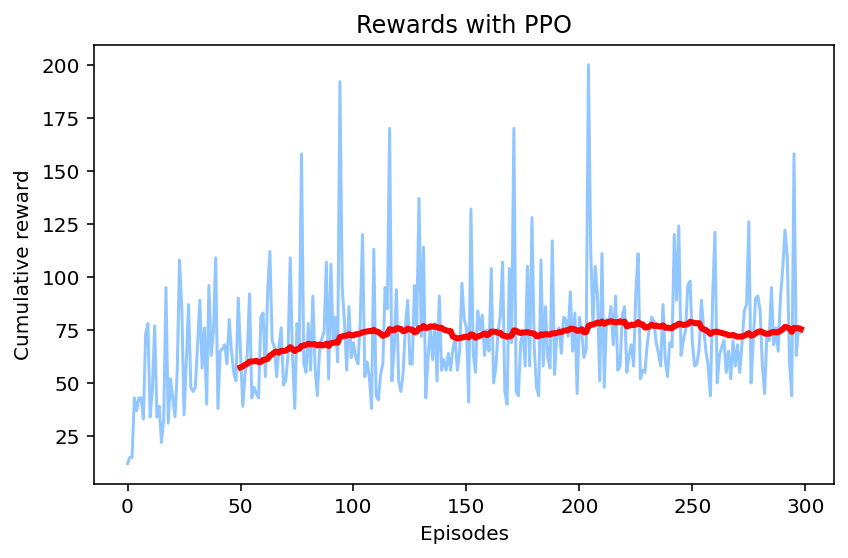

In [ ]:
plt.plot(reward_history[0:e], label='Reward')
n_ma = 50
moving_avg = np.convolve(reward_history, np.ones((n_ma,))/n_ma)[:e]
moving_avg[0:n_ma] = None
plt.plot(moving_avg, lw=3, color='red')
plt.title('Rewards with PPO')
plt.xlabel('Episodes')
plt.ylabel('Cumulative reward')
plt.tight_layout()
plt.show()

## Trying it

In [ ]:
env = wrap_env(gym.make("CartPole-v0"))
s = env.reset()
s = np.reshape(s, [1, dim_state_space])

done = False
cum_reward = 0

while not done:

  env.render()
  a = agent.policy(s)
  s_, r, done, _ = env.step(a)
  s_ = np.reshape(s_, [1, dim_state_space])
  agent.remember(s, a, r, s_, done)
  cum_reward += r
  s = s_

env.close()

print('We got a reward equal to {:.0f}'.format(cum_reward))

We got a reward equal to 84


In [ ]:
show_video()